# Event Impact Analysis - Deep Dive

This notebook focuses specifically on analyzing how market events affect Bitcoin volatility.

## Objectives:
- Analyze individual event impacts
- Compare different volatility measures
- Test different window sizes
- Identify the most significant events


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from datetime import timedelta
import sys

# Add src to path to import our analysis functions
project_root = Path('..')
sys.path.insert(0, str(project_root / 'src'))

from analysis.hypothesis_tests import event_impact_analysis, correlation_analysis

# Load data
btc_data = pd.read_csv(project_root / 'data' / 'raw' / 'bitcoin_prices.csv', 
                       parse_dates=['Date'], index_col='Date')
events_data = pd.read_csv(project_root / 'data' / 'processed' / 'market_events.csv', 
                          parse_dates=['date'])

print("Data loaded successfully!")
print(f"Bitcoin data: {btc_data.shape}")
print(f"Events data: {events_data.shape}")


Data loaded successfully!
Bitcoin data: (1796, 10)
Events data: (62, 7)


In [2]:
# Run event impact analysis with different window sizes
window_sizes = [3, 5, 7, 10, 15]
results_by_window = {}

print("Testing different window sizes for event impact analysis...")
for window in window_sizes:
    print(f"\nAnalyzing with {window}-day window...")
    impact_results = event_impact_analysis(btc_data, events_data, window_days=window)
    results_by_window[window] = impact_results
    
    # Count significant events
    significant_count = impact_results['significant'].sum()
    print(f"  Significant events: {significant_count}/{len(impact_results)} ({significant_count/len(impact_results)*100:.1f}%)")

# Show results for 10-day window (default)
print(f"\n=== DETAILED RESULTS (10-day window) ===")
impact_10d = results_by_window[10]
print(f"Total events analyzed: {len(impact_10d)}")
print(f"Significant events: {impact_10d['significant'].sum()}")
print(f"Mean volatility change: {impact_10d['volatility_change'].mean():.4f}")
print(f"Std volatility change: {impact_10d['volatility_change'].std():.4f}")

# Show most significant events
significant_events = impact_10d[impact_10d['significant'] == True].sort_values('p_value')
if len(significant_events) > 0:
    print(f"\nMost significant events:")
    for _, event in significant_events.head(5).iterrows():
        print(f"  {event['event']} (p={event['p_value']:.4f})")
else:
    print("\nNo events showed significant impact with 10-day window")


Testing different window sizes for event impact analysis...

Analyzing with 3-day window...
  Significant events: 0/62 (0.0%)

Analyzing with 5-day window...
  Significant events: 46/62 (74.2%)

Analyzing with 7-day window...
  Significant events: 51/62 (82.3%)

Analyzing with 10-day window...
  Significant events: 53/62 (85.5%)

Analyzing with 15-day window...
  Significant events: 55/62 (88.7%)

=== DETAILED RESULTS (10-day window) ===
Total events analyzed: 62
Significant events: 53
Mean volatility change: 0.0027
Std volatility change: 0.0094

Most significant events:
  Bitcoin crashes 50% in COVID Black Thursday (p=0.0000)
  Bitcoin crashes to $15.5K on FTX collapse (p=0.0000)
  Bitcoin falls below $53K on macro weakness (p=0.0000)
  Bitcoin breaks above $10K resistance (p=0.0000)
  Bitcoin surges past $65K on ETF hopes (p=0.0000)


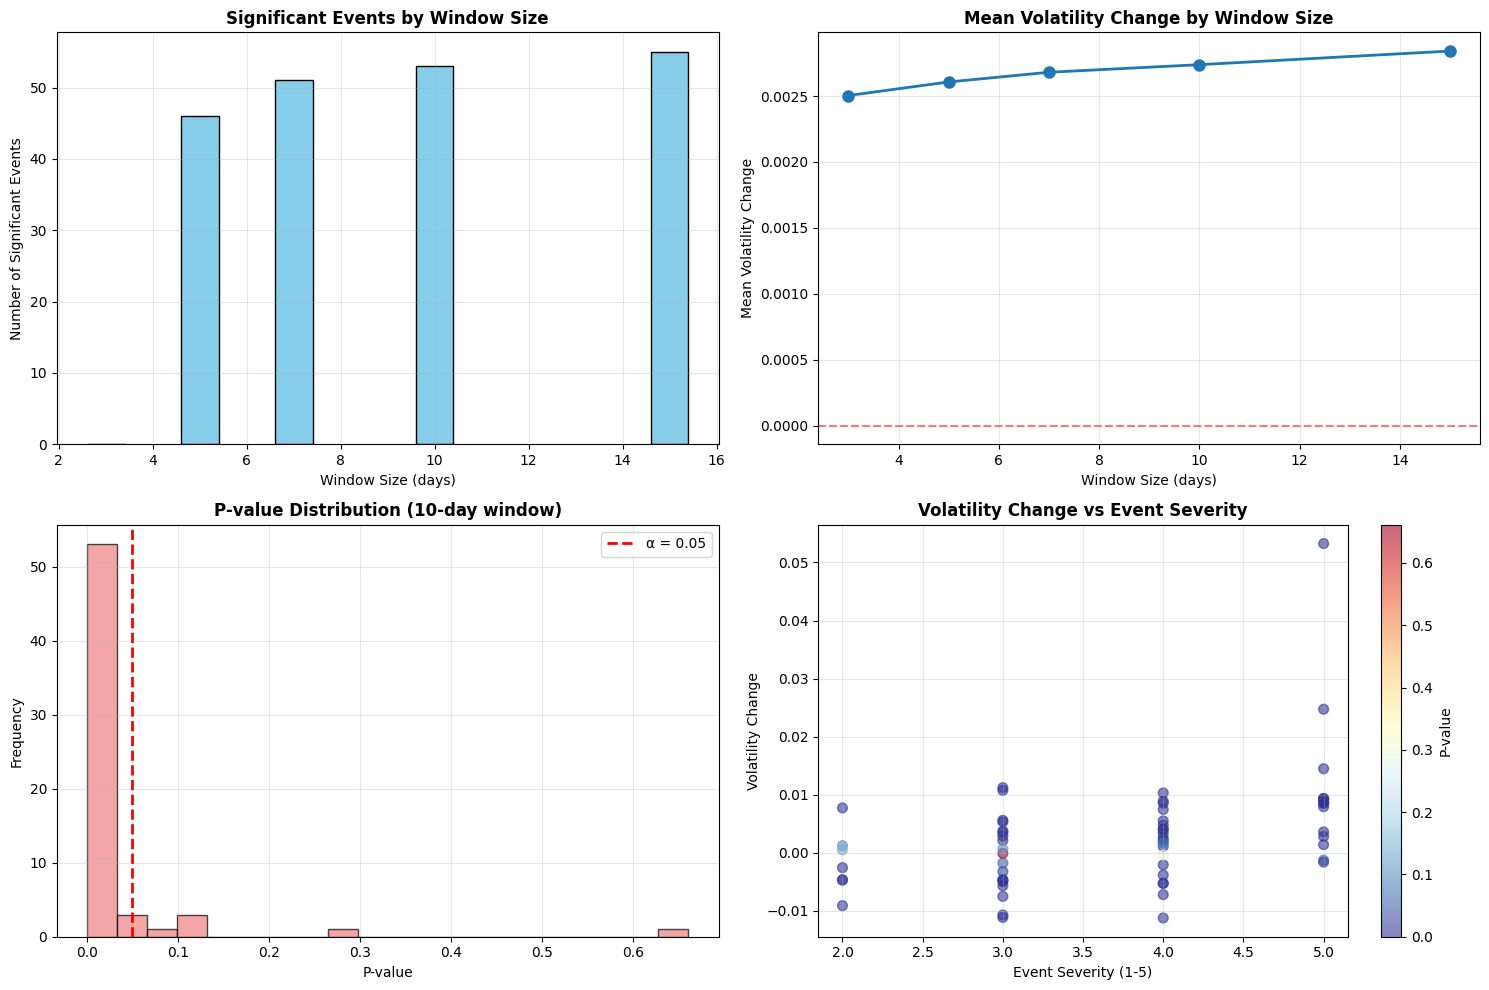

In [3]:
# Visualize window size comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Significant events by window size
window_sizes_list = list(results_by_window.keys())
significant_counts = [results_by_window[w]['significant'].sum() for w in window_sizes_list]

axes[0,0].bar(window_sizes_list, significant_counts, color='skyblue', edgecolor='black')
axes[0,0].set_title('Significant Events by Window Size', fontweight='bold')
axes[0,0].set_xlabel('Window Size (days)')
axes[0,0].set_ylabel('Number of Significant Events')
axes[0,0].grid(True, alpha=0.3)

# 2. Mean volatility change by window size
mean_changes = [results_by_window[w]['volatility_change'].mean() for w in window_sizes_list]
axes[0,1].plot(window_sizes_list, mean_changes, marker='o', linewidth=2, markersize=8)
axes[0,1].set_title('Mean Volatility Change by Window Size', fontweight='bold')
axes[0,1].set_xlabel('Window Size (days)')
axes[0,1].set_ylabel('Mean Volatility Change')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 3. P-value distribution for 10-day window
p_values = impact_10d['p_value'].dropna()
axes[1,0].hist(p_values, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,0].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
axes[1,0].set_title('P-value Distribution (10-day window)', fontweight='bold')
axes[1,0].set_xlabel('P-value')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Volatility change vs event severity
axes[1,1].scatter(impact_10d['severity'], impact_10d['volatility_change'], 
                  alpha=0.6, s=50, c=impact_10d['p_value'], cmap='RdYlBu_r')
axes[1,1].set_title('Volatility Change vs Event Severity', fontweight='bold')
axes[1,1].set_xlabel('Event Severity (1-5)')
axes[1,1].set_ylabel('Volatility Change')
axes[1,1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1,1].collections[0], ax=axes[1,1])
cbar.set_label('P-value')

plt.tight_layout()
plt.show()


In [4]:
# Compare different volatility measures
def analyze_volatility_measures(btc_data, events_data, window_days=10):
    """Compare Abs_Return vs Volatility_30d as volatility measures"""
    results = []
    
    for idx, event in events_data.iterrows():
        event_date = event['date']
        
        # Define before and after periods
        before_start = event_date - timedelta(days=window_days)
        before_end = event_date - timedelta(days=1)
        after_start = event_date + timedelta(days=1)
        after_end = event_date + timedelta(days=window_days)
        
        # Get data for both measures
        before_abs = btc_data[(btc_data.index >= before_start) & 
                              (btc_data.index <= before_end)]['Abs_Return'].dropna()
        after_abs = btc_data[(btc_data.index >= after_start) & 
                             (btc_data.index <= after_end)]['Abs_Return'].dropna()
        
        before_vol = btc_data[(btc_data.index >= before_start) & 
                              (btc_data.index <= before_end)]['Volatility_30d'].dropna()
        after_vol = btc_data[(btc_data.index >= after_start) & 
                             (btc_data.index <= after_end)]['Volatility_30d'].dropna()
        
        # Calculate changes
        abs_change = after_abs.mean() - before_abs.mean() if len(before_abs) > 0 and len(after_abs) > 0 else np.nan
        vol_change = after_vol.mean() - before_vol.mean() if len(before_vol) > 0 and len(after_vol) > 0 else np.nan
        
        # T-tests
        if len(before_abs) > 3 and len(after_abs) > 3:
            t_abs, p_abs = stats.ttest_ind(before_abs, after_abs)
        else:
            t_abs, p_abs = np.nan, np.nan
            
        if len(before_vol) > 3 and len(after_vol) > 3:
            t_vol, p_vol = stats.ttest_ind(before_vol, after_vol)
        else:
            t_vol, p_vol = np.nan, np.nan
        
        results.append({
            'event_id': event['event_id'],
            'event': event['event'],
            'severity': event['severity'],
            'abs_change': abs_change,
            'vol_change': vol_change,
            'abs_p_value': p_abs,
            'vol_p_value': p_vol,
            'abs_significant': p_abs < 0.05 if not np.isnan(p_abs) else False,
            'vol_significant': p_vol < 0.05 if not np.isnan(p_vol) else False
        })
    
    return pd.DataFrame(results)

# Run comparison
print("Comparing volatility measures...")
vol_comparison = analyze_volatility_measures(btc_data, events_data)

print(f"\n=== VOLATILITY MEASURES COMPARISON ===")
print(f"Events with significant Abs_Return impact: {vol_comparison['abs_significant'].sum()}")
print(f"Events with significant Volatility_30d impact: {vol_comparison['vol_significant'].sum()}")

# Correlation between the two measures
correlation = vol_comparison[['abs_change', 'vol_change']].corr().iloc[0, 1]
print(f"Correlation between measures: {correlation:.3f}")

# Show events where measures disagree
disagreement = vol_comparison[vol_comparison['abs_significant'] != vol_comparison['vol_significant']]
if len(disagreement) > 0:
    print(f"\nEvents where measures disagree ({len(disagreement)} events):")
    for _, event in disagreement.head(5).iterrows():
        print(f"  {event['event']}")
        print(f"    Abs_Return: p={event['abs_p_value']:.4f}, Vol_30d: p={event['vol_p_value']:.4f}")


Comparing volatility measures...

=== VOLATILITY MEASURES COMPARISON ===
Events with significant Abs_Return impact: 53
Events with significant Volatility_30d impact: 1
Correlation between measures: 0.385

Events where measures disagree (52 events):
  Bitcoin crashes 50% in COVID Black Thursday
    Abs_Return: p=0.0000, Vol_30d: p=0.0975
  Bitcoin rally begins on institutional demand
    Abs_Return: p=0.0066, Vol_30d: p=0.3893
  Bitcoin breaks $19K approaching ATH
    Abs_Return: p=0.0008, Vol_30d: p=0.6751
  Bitcoin breaks $20K all-time high
    Abs_Return: p=0.0000, Vol_30d: p=0.7719
  Bitcoin ends year up 300%
    Abs_Return: p=0.0050, Vol_30d: p=0.2804
